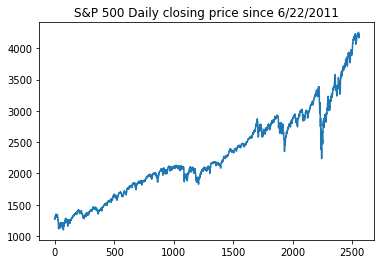

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Change this flag to False to not plot anything
PLOT = True

# Imports dataset
df = pd.read_csv("feasibility_spx.csv")

# Arranges data so that earliest comes first
data = df[::-1]

# Creates a list of closing prices as our features
closing_price = data['Close/Last'].to_numpy().reshape(-1,1)

if PLOT:
  plt.plot(closing_price)
  plt.title("S&P 500 Daily closing price since 6/22/2011")

  plt.show()

In [2]:
# Creates time series dataset to pass into RNN
# n_prev: how many previous values to include
def create_time_series(data, n_prev):
  x,y = [],[]
  for i in range(n_prev, data.shape[0]):
    x.append(data[i-n_prev:i,0])
    y.append(data[i,0])

  return np.array(x),np.array(y)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_prev = 20

# Separates training and testing data
data_train, data_test = closing_price[:2000], closing_price[2000:]

# TODO: stock price can go unlimited. Is minmax the best scaler?
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.fit_transform(data_test)

######################
# The LSTM (long short-term memory) RNN
# Using only 1 layer of LSTM should approximate the shape
# Using more layers may increase preciesness, but also may overfit
model = Sequential()
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mean_squared_error")

model.build((None, n_prev, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [4]:
x_train, y_train = create_time_series(data_train,n_prev)
x_test, y_test = create_time_series(data_test,n_prev)

# Note keras only take in (x,x,1) as input data
x_train = np.reshape(x_train, (-1,n_prev,1))
x_test = np.reshape(x_test, (-1,n_prev,1))

history = model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=0)

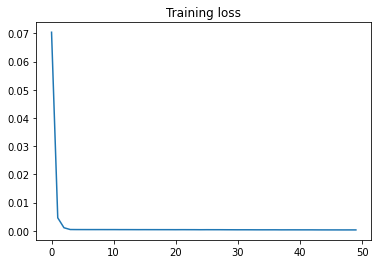

In [5]:
if PLOT:
  plt.plot(history.history['loss'])
  plt.title("Training loss")
  plt.show()

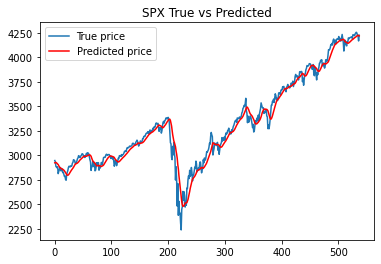

In [6]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

if PLOT:
  plt.plot(y_true, label="True price")
  plt.plot(y_pred, "r",label="Predicted price",)
  plt.title("SPX True vs Predicted")
  plt.legend()

  plt.show()